In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Equities', 'Foreign') + ['VT', 'ACWI'], 60, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-05-15 to 2019-07-12 - 77


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

75


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
EWZ,36,2.975896,2.635178,1.114237,22.059923,3.772108
ILF,36,1.899009,1.760020,1.056424,13.221454,3.070039
RSX,36,1.679878,1.274162,1.287274,12.990080,1.428578
FNDE,36,1.150788,1.415087,0.785185,8.185064,1.628895
DGS,36,1.025926,1.539023,0.640824,6.425804,3.353929
PXH,36,0.967822,1.425223,0.651224,6.748082,1.961680
DEM,36,0.912901,1.434641,0.608667,6.239693,1.795207
GEM,36,0.877483,1.625237,0.515494,5.665582,2.518333
VWO,36,0.863707,1.598507,0.515496,5.090524,2.832727


evicted EWA 0.871 -0.096
evicted EEMV 0.898 0.085
evicted EWL 0.883 -0.081
evicted EWT 0.898 -0.263
evicted ACWI 0.895 -0.387
evicted AIA 0.867 -0.129
evicted VIGI 0.833 -0.152
evicted EWY 0.653 -0.026
evicted ASHR 0.826 -0.037
evicted EWH 0.896 -0.167
evicted EPP 0.743 -0.166
evicted DGS 0.427 -0.060
evicted EPI 0.103 -0.198
retry backlogs ['IDEV', 'PXH', 'FNDE', 'INTF', 'ACWX', 'SPEM', 'EWU', 'GXC', 'VEU', 'SCHE', 'VYMI', 'IXUS', 'SCHF', 'VGK', 'TLTD', 'AAXJ', 'IEV', 'DEM', 'DBEF', 'IEMG', 'EEM', 'GSIE', 'PXF', 'SCZ', 'EWJ', 'VXUS', 'SPDW', 'EFA', 'VPL', 'EFAV', 'EFV', 'VT', 'EFG', 'IEUR', 'CWI', 'JPIN', 'EZU', 'VWO', 'IEFA', 'VEA', 'VSS', 'SCHC', 'IDV', 'FNDF', 'IPAC', 'MCHI', 'FEZ', 'DLS', 'FNDC', 'RODM', 'EWG', 'FDT', 'ILF', 'INDA', 'FXI', 'GEM', 'EWC', 'HEDJ', 'HEFA'] at 0.905/-0.51 - 1.661
evicted EWC 0.807 -0.381
evicted VSS 0.811 -0.210
evicted GEM 0.593 -0.031
evicted INDA 0.083 -0.133
retry backlogs ['IDEV', 'TLTD', 'ACWX', 'INTF', 'VYMI', 'VGK', 'JPIN', 'IXUS', 'IEV', 'VEU'

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,36.0,1.807960,1.075719,-0.296224,1.055742,1.703605,2.598576,4.070638,1.643810,13.505066,1.479374
RSX,36.0,1.679878,1.274162,-0.251254,0.736947,1.643410,2.466799,4.199471,1.287274,12.990080,1.428578
EWZ,36.0,2.975896,2.635178,-1.464949,0.753017,2.456738,5.226072,7.474701,1.114237,22.059923,3.772108
DXJ,36.0,0.409319,1.825535,-2.580381,-0.811693,-0.172787,1.231154,4.117778,0.202481,2.387542,4.053224


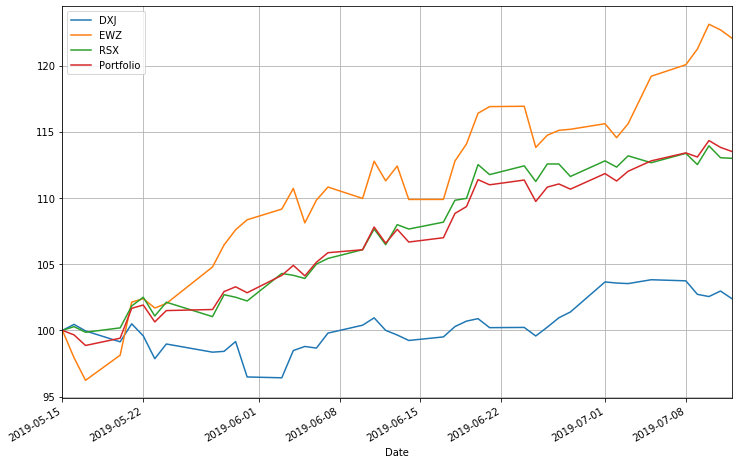

In [4]:
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio()
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio())
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)